In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# ===== General settings / constants =====

SS_MAP = {
    'H': 'H', 'G': 'H', 'I': 'H',   # different helix types -> H
    'B': 'E', 'E': 'E',             # beta-structures -> E
    'T': 'C', 'S': 'C', '~': 'C', 'P': 'C'  # everything else -> C
}

FILE_PATHS = {
    'WT': 'WT_dssp.dat',
    'P48L_H83Y': 'P48L_H83Y_dssp.dat',
    'R131P_G55C': 'R131P_G55C_dssp.dat',
}

PLOT_DIR = 'notebooks/plots'
os.makedirs(PLOT_DIR, exist_ok=True)


In [3]:
# ===== Data processing functions =====

def read_and_convert_sse(file_path: str) -> pd.DataFrame:
    """Reads a DSSP file and converts 7-state assignment into 3-state (H/E/C)."""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f]

    # each line -> list of characters
    data = [list(line) for line in lines]
    df = pd.DataFrame(data)

    # replace 7-state with 3-state
    df_reduced = df.replace(SS_MAP)
    return df_reduced

In [4]:
def sse_percentages(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame with percentages of H/E/C per residue position.
    Index — residue number (0..N-1), columns — 'H','E','C'.
    """
    res = {}
    for state in ('H', 'E', 'C'):
        # fraction of this state across frames for each residue
        res[state] = (df == state).mean(axis=0) * 100.0
    return pd.DataFrame(res)

In [5]:
def print_global_sse_stats(label: str, perc_df: pd.DataFrame) -> None:
    """Prints the average percentage over the entire protein."""
    avg_helix = perc_df['H'].mean()
    avg_sheet = perc_df['E'].mean()
    avg_coil  = perc_df['C'].mean()
    print(f"{label} - Helix: {avg_helix:.2f}%, Sheet: {avg_sheet:.2f}%, Coil: {avg_coil:.2f}%")


In [6]:
# ===== File reading =====

sse_frames = {label: read_and_convert_sse(path) for label, path in FILE_PATHS.items()}
sse_percent_data = {label: sse_percentages(df) for label, df in sse_frames.items()}

# Print average percentages
for label, perc_df in sse_percent_data.items():
    print_global_sse_stats(label, perc_df)

WT - Helix: 36.41%, Sheet: 2.15%, Coil: 61.43%
P48L_H83Y - Helix: 38.26%, Sheet: 2.75%, Coil: 58.98%
R131P_G55C - Helix: 36.84%, Sheet: 1.69%, Coil: 61.47%


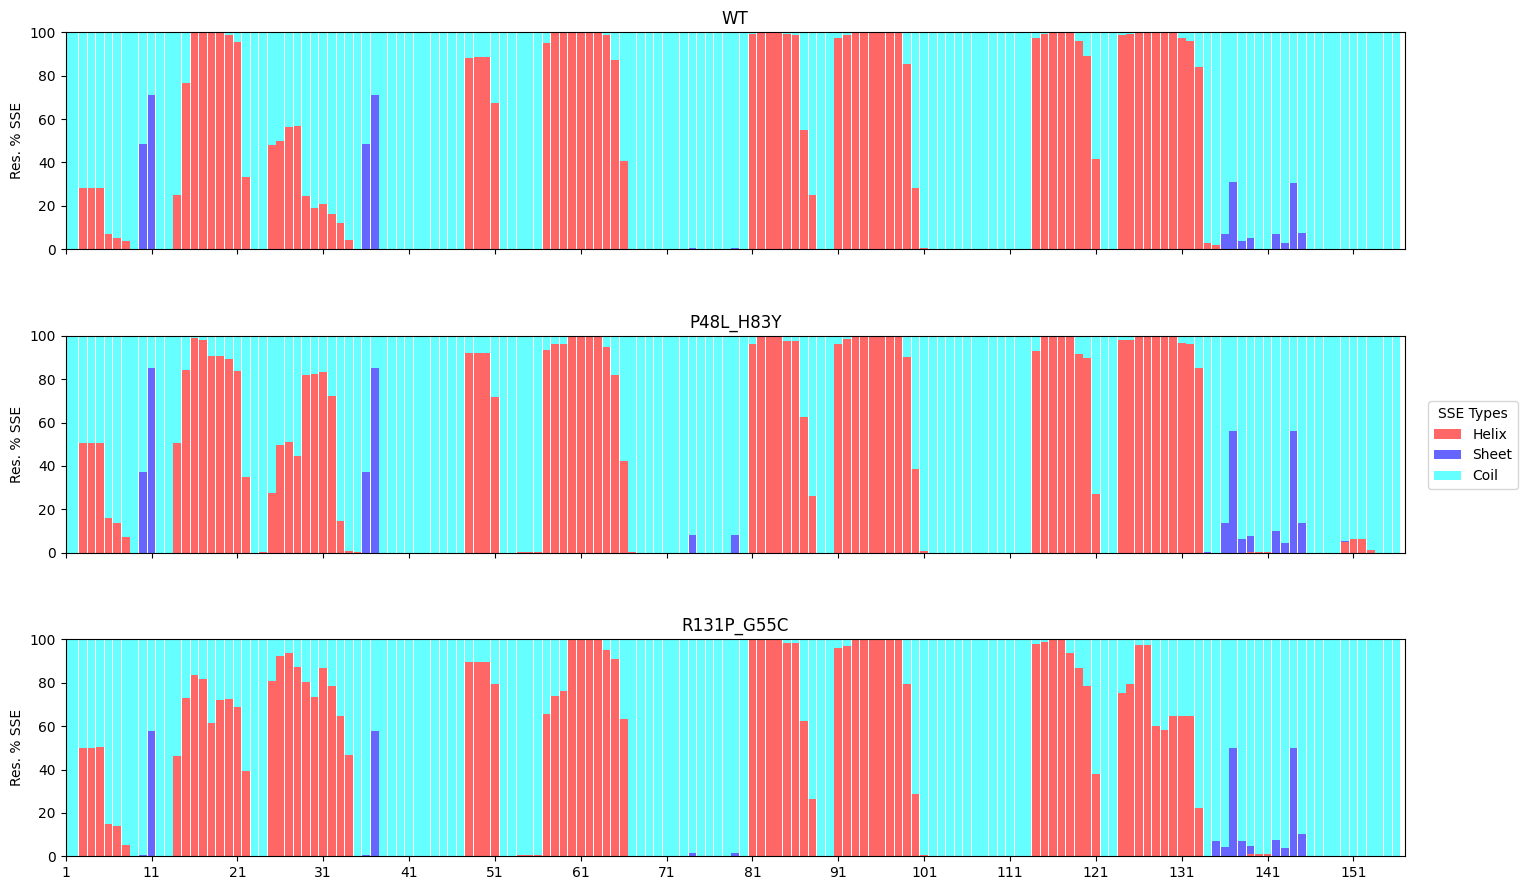

In [7]:
# ===== 1) Stacked bar plots of SSE percentages per residue =====

def plot_sse_comparison(perc_df: pd.DataFrame, title: str, ax: plt.Axes) -> None:
    """
    perc_df: DataFrame with columns 'H','E','C' and residue index.
    """
    n_res = perc_df.shape[0]
    positions = np.arange(n_res)

    h = perc_df['H'].to_numpy()
    e = perc_df['E'].to_numpy()
    c = perc_df['C'].to_numpy()

    # Restored original colors
    ax.bar(positions, h, color='red',  label='Helix', alpha=0.6, width=0.9)
    ax.bar(positions, e, color='blue', bottom=h, label='Sheet', alpha=0.6, width=0.9)
    ax.bar(positions, c, color='cyan', bottom=h + e, label='Coil', alpha=0.6, width=0.9)

    ax.set_ylim(0, 100)
    ax.set_xlim(0, n_res)

    ax.set_ylabel('Res. % SSE')
    ax.set_title(title)

    # X-axis ticks: every 10 residues
    step = 10
    tick_positions = np.arange(0, n_res, step)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_positions + 1)  # numbering starts from 1


# Figure for percentages
fig1, axs1 = plt.subplots(len(FILE_PATHS), 1,
                          figsize=(15, 3 * len(FILE_PATHS)),
                          sharex=True)

if len(FILE_PATHS) == 1:
    axs_iter = [axs1]
else:
    axs_iter = axs1

for ax, (label, perc_df) in zip(axs_iter, sse_percent_data.items()):
    plot_sse_comparison(perc_df, label, ax)

# Legend
handles, labels = axs_iter[0].get_legend_handles_labels()
fig1.legend(handles, labels, loc='center right',
            bbox_to_anchor=(1.02, 0.5), title="SSE Types")

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.subplots_adjust(hspace=0.4)

plt.savefig(os.path.join(PLOT_DIR, 'sse_comparison_all.png'), dpi=300)
plt.show()

C:\Users\anast\AppData\Local\Temp\ipykernel_43856\3807806761.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(COLOR_MAP).to_numpy()
C:\Users\anast\AppData\Local\Temp\ipykernel_43856\3807806761.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(COLOR_MAP).to_numpy()
C:\Users\anast\AppData\Local\Temp\ipykernel_43856\3807806761.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_o

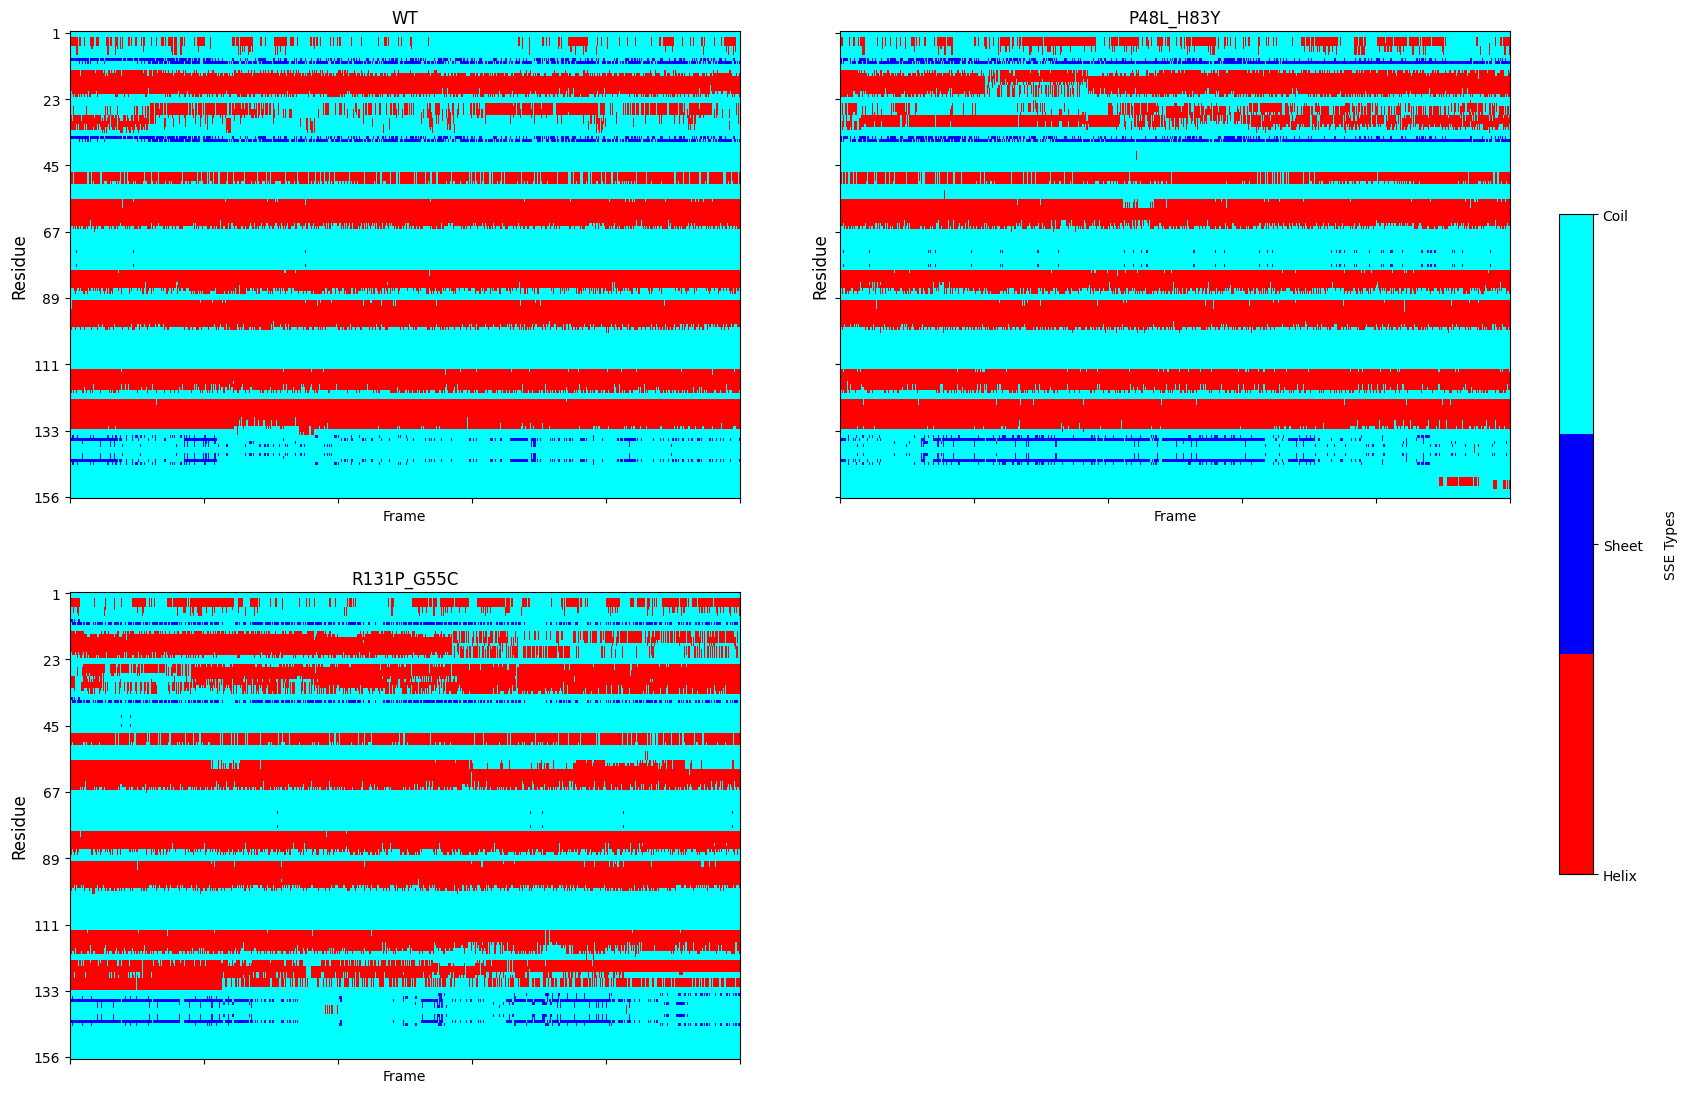

In [8]:
# ===== 2) SSE “maps” (matshow) by frames/residues =====

COLOR_MAP = {'H': 0, 'E': 1, 'C': 2}
CMAP = ListedColormap(['red', 'blue', 'cyan'])

def df_to_numeric_matrix(df: pd.DataFrame) -> np.ndarray:
    """Convert H/E/C into 0/1/2 via replace (faster than applymap)."""
    return df.replace(COLOR_MAP).to_numpy()

# 4x2 grid
n_rows, n_cols = 4, 2
fig2, axs2 = plt.subplots(n_rows, n_cols, figsize=(17, 22),
                          sharex=True, sharey=True)
axs2 = axs2.flatten()

for i, (label, df) in enumerate(sse_frames.items()):
    if i >= len(axs2):
        break

    numeric_matrix = df_to_numeric_matrix(df)

    # numeric_matrix: shape = (n_frames, n_res)
    n_frames, n_res = numeric_matrix.shape

    ax = axs2[i]
    im = ax.matshow(numeric_matrix.T, aspect='auto',
                    cmap=CMAP, vmin=0, vmax=2)

    ax.set_title(label)
    ax.set_ylabel('Residue', fontsize=12)
    ax.set_xlabel('Frame')

    # Y: residues 1..N, 8 tick labels
    y_ticks = np.linspace(0, n_res - 1, 8)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels((y_ticks + 1).astype(int))

    # X: frames, 6 tick labels
    x_ticks = np.linspace(0, n_frames - 1, 6)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks.astype(int))
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

# Remove extra axes
for j in range(i + 1, len(axs2)):
    fig2.delaxes(axs2[j])

# Colorbar
cbar_ax = fig2.add_axes([0.92, 0.6, 0.02, 0.3])
cbar = fig2.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Helix', 'Sheet', 'Coil'])
cbar.set_label("SSE Types", rotation=90, labelpad=15)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(hspace=0.2, wspace=0.15)

plt.savefig(os.path.join(PLOT_DIR, 'sse_horizontal_line_comparison_2x_with_legend.png'),
            dpi=300)
plt.show()